In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/hereisburak/pins-face-recognition')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nguyenthanhlongsn
Your Kaggle Key: ··········


100%|██████████| 372M/372M [00:02<00:00, 139MB/s]


In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "/content/pins-face-recognition/105_classes_pins_dataset"
train_dataset = image_dataset_from_directory(directory, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset='training', seed=42)
validation_dataset = image_dataset_from_directory(directory, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset='validation', seed=42)

Found 17534 files belonging to 105 classes.
Using 14028 files for training.
Found 17534 files belonging to 105 classes.
Using 3506 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

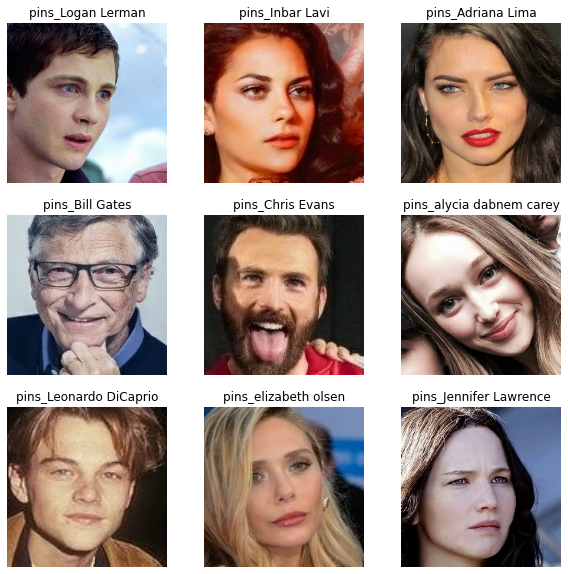

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
def data_augmenter():

  data_augmentation = tf.keras.Sequential([
  tfl.experimental.preprocessing.RandomFlip("horizontal"),
  tfl.experimental.preprocessing.RandomRotation(0.2),
  ])

  return data_augmentation

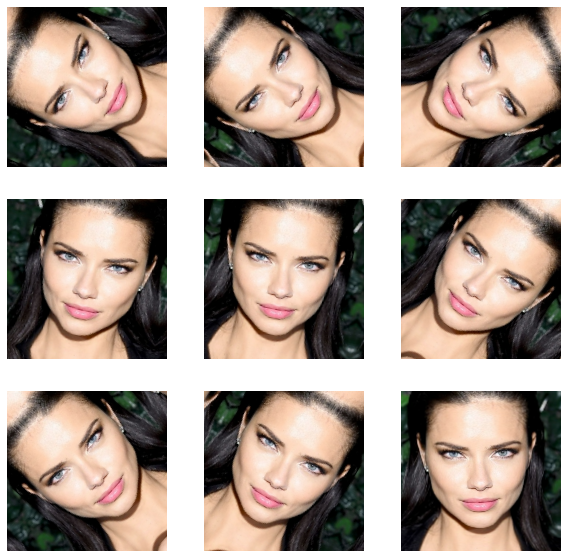

In [9]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=True, weights='imagenet')

14536120/14536120 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 1000])

In [ ]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=1)

35363/35363 [==============================] - 0s 0us/step


[[('n02667093', 'abaya', 0.12675697)],
 [('n04350905', 'suit', 0.59033287)],
 [('n03676483', 'lipstick', 0.403044)],
 [('n04584207', 'wig', 0.062373687)],
 [('n02667093', 'abaya', 0.6637593)],
 [('n03814639', 'neck_brace', 0.91424394)],
 [('n04162706', 'seat_belt', 0.12518398)],
 [('n03676483', 'lipstick', 0.40455866)],
 [('n02992529', 'cellular_telephone', 0.24337527)],
 [('n04591157', 'Windsor_tie', 0.25358033)],
 [('n03595614', 'jersey', 0.06349809)],
 [('n03814639', 'neck_brace', 0.06632505)],
 [('n04350905', 'suit', 0.11233738)],
 [('n04584207', 'wig', 0.38435194)],
 [('n04584207', 'wig', 0.35775992)],
 [('n02669723', 'academic_gown', 0.1446416)],
 [('n02786058', 'Band_Aid', 0.09573367)],
 [('n03676483', 'lipstick', 0.14015156)],
 [('n02883205', 'bow_tie', 0.56408083)],
 [('n02786058', 'Band_Aid', 0.07836006)],
 [('n02492035', 'capuchin', 0.118641116)],
 [('n04584207', 'wig', 0.71469486)],
 [('n02786058', 'Band_Aid', 0.3297929)],
 [('n03724870', 'mask', 0.7177204)],
 [('n04591157'

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet') 

base_model.trainable = False 

inputs = tf.keras.Input(shape=IMG_SHAPE) 

x = data_augmentation(inputs)

x = preprocess_input(x) 

x = base_model(x, training=False) 

x = tf.keras.layers.GlobalAveragePooling2D()(x) 

x = tfl.Dropout(.2)(x)

outputs = tf.keras.layers.Dense(105)(x)

model1 = tf.keras.Model(inputs, outputs)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
history1 = model1.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
439/439 [==============================] - 301s 675ms/step - loss: 4.0617 - accuracy: 0.1003 - val_loss: 3.4015 - val_accuracy: 0.1742
Epoch 2/10
439/439 [==============================] - 280s 639ms/step - loss: 3.2803 - accuracy: 0.2029 - val_loss: 3.1625 - val_accuracy: 0.2248
Epoch 3/10
439/439 [==============================] - 290s 660ms/step - loss: 3.0236 - accuracy: 0.2495 - val_loss: 3.0068 - val_accuracy: 0.2441
Epoch 4/10
439/439 [==============================] - 290s 661ms/step - loss: 2.8850 - accuracy: 0.2802 - val_loss: 2.9041 - val_accuracy: 0.2737
Epoch 5/10
439/439 [==============================] - 292s 665ms/step - loss: 2.7811 - accuracy: 0.3023 - val_loss: 2.8519 - val_accuracy: 0.2841
Epoch 6/10
439/439 [==============================] - 288s 655ms/step - loss: 2.6915 - accuracy: 0.3192 - val_loss: 2.8175 - val_accuracy: 0.2944
Epoch 7/10
439/439 [==============================] - 284s 646ms/step - loss: 2.6277 - accuracy: 0.3334 - val_loss: 2.8275 -

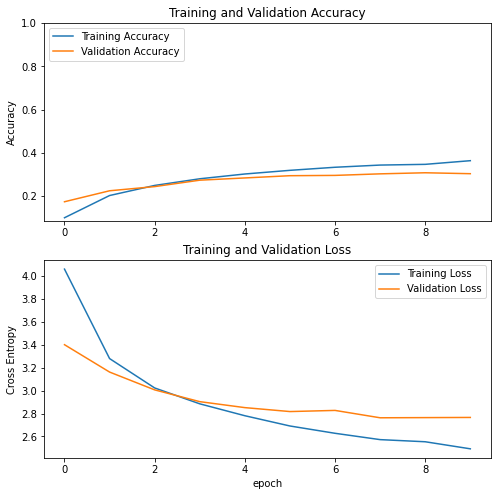

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [38]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
history2 = model1.fit(train_dataset, validation_data=validation_dataset, epochs=13, initial_epoch=history1.epoch[-1])

Epoch 10/13
439/439 [==============================] - 1048s 2s/step - loss: 2.6675 - accuracy: 0.3166 - val_loss: 2.4439 - val_accuracy: 0.3680
Epoch 11/13
439/439 [==============================] - 1047s 2s/step - loss: 2.1235 - accuracy: 0.4351 - val_loss: 2.0966 - val_accuracy: 0.4490
Epoch 12/13
439/439 [==============================] - 1040s 2s/step - loss: 1.7815 - accuracy: 0.5026 - val_loss: 1.7662 - val_accuracy: 0.5321
Epoch 13/13
439/439 [==============================] - 1044s 2s/step - loss: 1.5241 - accuracy: 0.5742 - val_loss: 1.7272 - val_accuracy: 0.5446


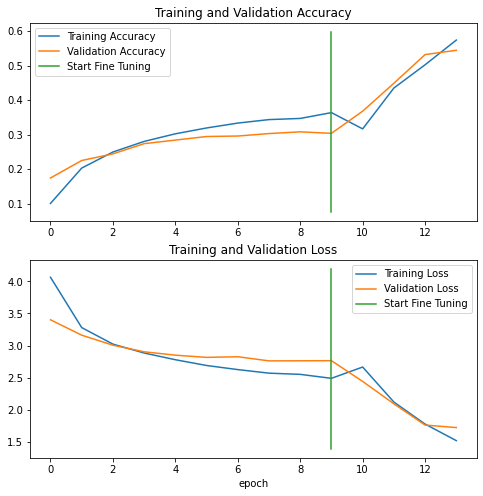

In [ ]:
acc += history2.history['accuracy']
val_acc += history2.history['val_accuracy']

loss += history2.history['loss']
val_loss += history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([history1.epoch[-1], history1.epoch[-1]], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([history1.epoch[-1], history1.epoch[-1]], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
image_batch, label_batch = next(iter(test_dataset))
feature_batch = model1(image_batch)
predictions = tf.math.argmax(tf.nn.softmax(feature_batch, axis=1), axis=1)

In [42]:
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(label_batch, predictions)
accuracy.result().numpy()

1.0

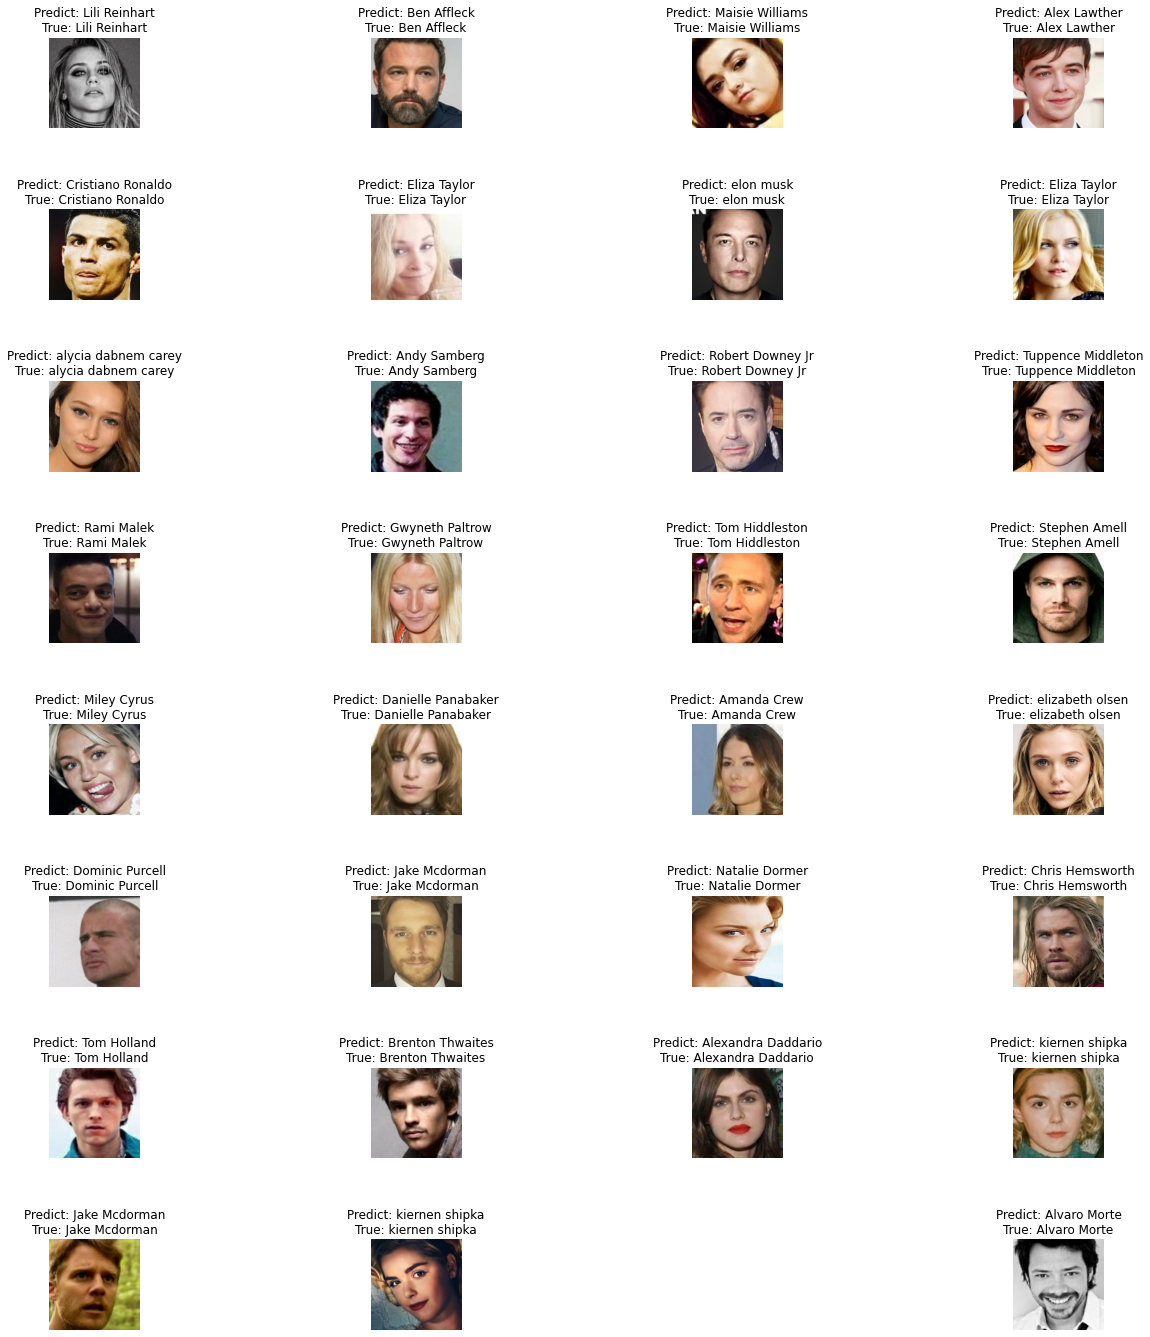

In [43]:
plt.figure(figsize=(20, 20))
for i in range(32):
  ax = plt.subplot(8, 4, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  plt.title('Predict: ' + class_names[predictions[i]].split('_')[1] + '\nTrue: ' + class_names[label_batch[i]].split('_')[1])
  plt.tight_layout(pad=5.0)
  plt.axis("off")

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
model1.save('/content/drive/MyDrive/Colab Notebooks/parameters.h5')

In [12]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/parameters.h5')

In [13]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             